In [8]:
#import all da nice stuff
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import gzip
import glob
import re
from DMS_utils import dna_rev_comp, translate_dna2aa
import pysam
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
import shutil

In [9]:
base_dir = os.getcwd() 
amplicon = "RRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRV"
amplicon_DNA = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
LOV = "LATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAK"
catch_left = 'AAGCAGCGGT'
catch_right = 'GGGAGCCTGC'
offset_left = 3
offset_right=5

genetic_code = {
  'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
  'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
  'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
  'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
  'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
  'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
  'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
  'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
  'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
  'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
  'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
  'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
  'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
  'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
  'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
  'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
}


quality_score = {
  '!':0, '"':1, '#':2, '$':3, '%':4, '&':5, "'":6, '(':7, ')':8, '*':9,
  '+':10, ',':11, '-':12, '.':13, '/':14, '0':15, '1':16, '2':17, '3':18, '4':19,
  '5':20, '6':21, '7':22, '8':23, '9':24, ':':25, ';':26, '<':27, '=':28, '>':29,
  '?':30, '@':31, 'A':32, 'B':33, 'C':34, 'D':35, 'E':36, 'F':37, 'G':38, 'H':39, 'I':40
}

In [10]:
len(amplicon_DNA)

489

# Functions

In [11]:
def normalize_data(variants):
    #normalize data to read counts
    fractions_dict = {}
    for key, value in variants.items():
        for idx, wt in enumerate(variants[key].columns.str[0]):
            variants[key].loc[wt][idx] = variants[key].loc[wt][idx] - variants[key].loc['wt'][idx]
        sum_calls = value.sum()-value.loc['wt']
        print(f'Minimum coverage of mutated position: {min(sum_calls)}')
        fractions_dict[key] = value/(value.sum()-value.loc['wt'])
        variants[key].drop('N16', axis=1, inplace=True)
        fractions_dict[key].drop('N16', axis=1, inplace=True)
        fractions_dict[key].drop('wt', axis=0, inplace=True)
    return fractions_dict

def normalize_to_input(variants_fractions, initial_lib):
    for key, value in variants_fractions.items():
        if key != initial_lib:
            variants_fractions[key] = variants_fractions[key]/variants_fractions[initial_lib]
            variants_fractions[key] = np.log2(variants_fractions[key])
            variants_fractions[key].replace([np.inf, -np.inf], np.nan, inplace=True)
    return variants_fractions

def r(x, y):
    return stats.spearmanr(x, y)

def correlation_plot(data, combination):
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(y=data[:,0], x=data[:,1], color='grey', ci=None, 
        scatter_kws={'alpha':.6, 'linewidth':0}, line_kws={"linewidth":0, 
        'label':f"Spearman's r: {round(r(data[~np.isnan(data).any(axis=1),:][:,0], data[~np.isnan(data).any(axis=1),:][:,1])[0], 2)}"})
    plt.xlabel('Log2 enrichment rep-1')
    plt.ylabel('Log2 enrichment rep-2')
    plt.xlim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    plt.ylim(data[~np.isnan(data).any(axis=1),:].min().min()-.5, data[~np.isnan(data).any(axis=1),:].max().max() +.5)
    sns.despine()
    g.tick_params(width=2)
    g.legend(frameon=False, loc='upper right')
    plt.title(f"{combination}", y=1.03)
    #plt.savefig(f"{fig_folder}/correlation_{combination}_{property}.svg")

def library_coverage(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    plt.figure(figsize=(5,5))
    ax = sns.heatmap(data=data, cmap='mako', cbar_kws={'label': f"Read counts"}, square=True, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

map = sns.diverging_palette(10, 260, s=100, l=30, as_cmap=True)
def mutation_enrichment(data, name):
    #process data
    AA_order = ['A','I','L','M','F','W','Y','V','S','T','N','Q','R','H','K','D','E','C','G','P','*']
    data = data.loc[AA_order]
    mask = data.isnull()

    #center colorbar
    vcenter = 0
    vmin, vmax = data.min().min(), data.max().max()
    normalize = mcolors.TwoSlopeNorm(vcenter=0.01, vmin=0, vmax=0.1)

    plt.figure(figsize=(24,4))
    ax = sns.heatmap(data=data, cmap='viridis', cbar_kws={'label': f"counts"}, square=True, norm=normalize, mask=mask)
    plt.title(name)
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(2)
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    #plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

def correlation_light_dark(dark, light, name, x_name='Light', y_name='Dark'):
    light_dark = pd.DataFrame(np.column_stack([dark.stack(dropna=False).to_list(),
                                    light.stack(dropna=False).to_list()]), columns=['Dark', 'Light'])
    stop_codons = pd.DataFrame(np.column_stack([dark.loc['*'].to_list(),
                                light.loc['*'].to_list()]), columns=['Dark', 'Light'])
    #light_dark = light_dark.iloc[1:-1,:]
    sns.set(font_scale = 1)
    sns.set_style("ticks", rc={'font.family':'sans-serif', 'font.sans-serif':'Droid Sans'})
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    ax = sns.scatterplot(data=light_dark, x='Light', y='Dark', color='grey', alpha=.4, linewidth=0, legend=False)
    ax1 = sns.scatterplot(data=stop_codons, x='Light', y='Dark', color='red', alpha=1, linewidth=0, legend=False)
    plt.xlabel(f"{x_name} log2 enriched read counts")
    plt.ylabel(f"{y_name} log2 enriched read counts")
    plt.xlim(light_dark.min().min()-1, light_dark.max().max() +1)
    plt.ylim(light_dark.min().min()-1, light_dark.max().max() +1)
    sns.despine()
    plt.axvline(0, 1,0, color='black', linewidth=2)
    plt.axhline(0, 1,0, color='black', linewidth=2)
    plt.title(f"{name} light vs dark")
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)



In [7]:
def find(string, value_list):
    indexes = [string.find(letter) for letter in value_list]
    try: 
        ind = min([index for index in indexes if index != -1])
    except:
        ind = 250
    return ind

def read_sequences(file):
    """
    read sequences from fastq files while filtering for quality score (read is aborted at first nt with higher error rate than 1%)
    returns list of sequences
    """
    sequences = []
    a_sequences = []
    b_sequences = []
    y=0
    quality_score = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*','+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5']
    with open(f'{base_dir}/data/fastq/{file}_R1_001.fastq', "rt") as a_file, open(f'{base_dir}/data/fastq/{file}_R2_001.fastq', "rt") as b_file:
        a_reader = QualityIO.FastqGeneralIterator(a_file)
        b_reader = QualityIO.FastqGeneralIterator(b_file)
        for total_read, (a, b) in enumerate(zip(a_reader, b_reader)):
                #if y < 10000:
                a_id, a_seq, a_qual = a
                b_id, b_seq, b_qual = b
                cutoff_a = find(a_qual, quality_score)
                cutoff_b = find(b_qual, quality_score)
                a_sequences.append(a_seq[:cutoff_a])
                b_sequences.append(b_seq[:cutoff_b])
                
                y+=1
                #else: 
                #    break
        print("total reads", total_read)
    return a_sequences, b_sequences

def gather_variants(a_seq, b_seq, DNA, insert_pos=0):
    """
    returns a dictionary with the counts of each amino acid at each position
    """
    mutation_dict = {}
    undefined = 0
    counter = 0
    catch_length = len(catch_left)
    gene_len = len(LOV)*3
    stops = 0
    
    for idx in range(len(LOV)):
        mutation_dict[idx] = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 
                                                'H':0, 'I':0, 'K':0, 'L':0, 'M':0, 'N':0, 
                                                'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 
                                                'W':0, 'Y':0, '*':0, 'wt':0}
    for a_seq, b_seq in zip(a_seq, b_seq):
        
        counter +=1
        if counter%100000 == 0:
            print(counter)
        if catch_left in a_seq:
            index = a_seq.index(catch_left) + catch_length
            gene_a = a_seq[index:]
            tr_a = translate_dna2aa(gene_a)
            for idx, pos in enumerate(tr_a):
                mutation_dict[idx][pos] += 1
        if dna_rev_comp(catch_right) in b_seq:
            index = b_seq.index(dna_rev_comp(catch_right)) + catch_length
            gene_b = dna_rev_comp(b_seq[index:(len(b_seq)-index)//3*3+index])
            tr_b = translate_dna2aa(gene_b)
            tr_b = tr_b[::-1]
            for idx, pos in enumerate(tr_b):
                mutation_dict[len(LOV)-idx-1][pos] += 1

    return mutation_dict


def process_reads(variant, AA_sequence, DNA):
    variants_dict = {}
    path = f'{base_dir}/data/fastq'
    filenames = glob.glob(f'{path}/*')
    # if os.path.isfile(f'{path}/{variant}_variants.pickle'):
    #     with open(f'{path}/{variant}_variants.pickle', 'rb') as f:
    #         variants_dict = pkl.load(f)
    # else:
    for name in filenames: 
        if '_R1' in name:
            name = name.split('/')[-1].split('_R')[0]
            peptide_length = len(AA_sequence)
            length = len(AA_sequence) * 3
            flank_len = 10
            #process sequences
            sequences = []
            results = []
            f1 = name
            a_seq, b_seq = read_sequences(f1)
            variants_dict[name] = gather_variants(a_seq, b_seq, amplicon, DNA)
            print(f'Done: {name}')

        with open(f'{path}/{variant}_variants.pickle', 'wb') as handle:
            pkl.dump(variants_dict, handle)
    return variants_dict


# AraC analysis

In [22]:
DP6_variants = process_reads('DP6', amplicon, amplicon_DNA)
DP6_variants['RL1'] = pd.DataFrame.from_dict(DP6_variants['RL1'])
DP6_variants['DP6'] = pd.DataFrame.from_dict(DP6_variants['DP6'])

total reads 59258
Done: DP6
total reads 47232
Done: RL8
total reads 48195
Done: RL1


In [35]:
DP6_seq = read_sequences("DP6")
DP6_vars = process_reads("DP6", amplicon, amplicon_DNA)


total reads 59258


total reads 59258
Done: DP6
total reads 47232
Done: RL8
total reads 48195
Done: RL1


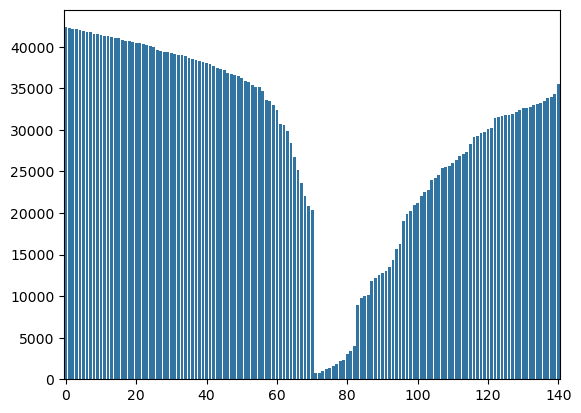

In [17]:
ax = sns.barplot(DP6_variants["DP6"].sum())
plt.xticks([0,20,40,60,80,100,120,140])
plt.show()


### NOTE that the quality score cutoff is set to a 1 % error rate

In [18]:
DP6_variants['DP6'] = DP6_variants['DP6'].iloc[:,:70]

In [19]:
coverage = DP6_variants['DP6'].sum().sum()/(DP6_variants['DP6'].max().max()*DP6_variants['DP6'].shape[1])*100
print(f'The illumina paired reads cover on average {coverage.round(1)} % of the LOV sequence')

mut_rate = DP6_variants['DP6'].max()/DP6_variants['DP6'].sum()-1
mut_rate = abs(mut_rate.sum())
print(f'The mutation rate is estimated to be {mut_rate.round(1)} mutations per sequence')
print(f'If we correct for the coverag, we expect a mutation rate of {round(mut_rate/coverage*100,2)} mutations per sequence')

The illumina paired reads cover on average 88.0 % of the LOV sequence
The mutation rate is estimated to be 0.9 mutations per sequence
If we correct for the coverag, we expect a mutation rate of 0.97 mutations per sequence


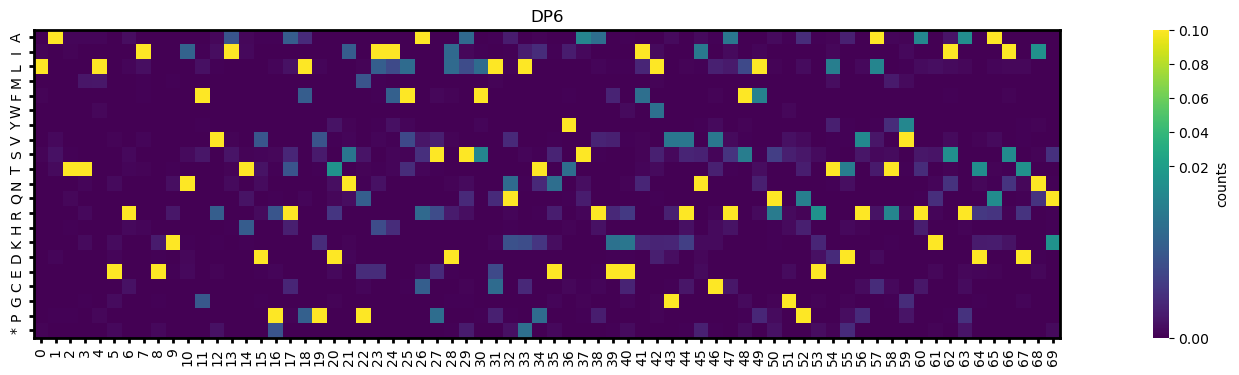

In [21]:
DP6_relative = DP6_variants['DP6']/DP6_variants['DP6'].sum()
mutation_enrichment(DP6_relative, 'DP6')